# Import Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor

plt.style.use('seaborn-darkgrid')

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [3]:
HealthInsDF = pd.read_csv('COVID_HealthIns.csv', index_col = 0)
HealthInsDF.head()

,State,cases,deaths,Population Per State (2014),Total Health Insurance Enrollment Per State (2014),Total Health Insurance Enrollment (Percent),Medicare Enrollment Per State (2014),Medicare Enrollment (Percent),Medicaid Enrollment Per State (2014),Medicaid Enrollment (Percent),Private Enrollment Per State (2014),Private Enrollment (Percent)
0,Alabama,387786,14345,4843,4977,102.766880,947,19.553995,988,20.400578,3042,62.812306
1,Alaska,18316,367,737,611,82.903664,80,10.854817,113,15.332429,418,56.716418
2,Arizona,426614,18857,6720,6219,92.544643,1096,16.309524,1388,20.654762,3735,55.580357
3,Arkansas,161569,3301,2967,2986,100.640377,584,19.683182,812,27.367711,1590,53.589484
4,California,2664110,102387,38681,38951,100.698017,5476,14.156821,11505,29.743285,21970,56.797911


In [4]:
HealthInsDF = HealthInsDF.drop(columns = [col for col in HealthInsDF.columns if '(Percent)' in col])
HealthInsDF = HealthInsDF.drop(columns = ['cases', 'deaths', 'Population Per State (2014)'])
HealthInsDF.head()

,State,Total Health Insurance Enrollment Per State (2014),Medicare Enrollment Per State (2014),Medicaid Enrollment Per State (2014),Private Enrollment Per State (2014)
0,Alabama,4977,947,988,3042
1,Alaska,611,80,113,418
2,Arizona,6219,1096,1388,3735
3,Arkansas,2986,584,812,1590
4,California,38951,5476,11505,21970


In [5]:
COVID = pd.read_csv('COVID.csv', index_col = 0)
COVID.head()

,State,cases,deaths
0,Alabama,26912,785
1,Alaska,751,10
2,Arizona,39298,1228
3,Arkansas,13191,188
4,California,159098,5202


In [6]:
HealthInsDF = pd.merge(HealthInsDF, COVID, how = 'left', on = 'State')
HealthInsDF.head()

,State,Total Health Insurance Enrollment Per State (2014),Medicare Enrollment Per State (2014),Medicaid Enrollment Per State (2014),Private Enrollment Per State (2014),cases,deaths
0,Alabama,4977,947,988,3042,26912,785
1,Alaska,611,80,113,418,751,10
2,Arizona,6219,1096,1388,3735,39298,1228
3,Arkansas,2986,584,812,1590,13191,188
4,California,38951,5476,11505,21970,159098,5202


In [7]:
test_len = int(0.25 * len(HealthInsDF))
train_len = len(HealthInsDF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = HealthInsDF[:train_len]
test = HealthInsDF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 7)
Test Set Shape: (12, 7)


In [8]:
features_list = ['Medicare Enrollment Per State (2014)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 99.02885397886618
Train MSE Value: 14057.182718704431
Train RMS Value: 118.56299051012685
Train R2 Score: 0.999997095515832


Test MAE Value: 44341.254399617515
Test MSE Value: 8063156908.655541
Test RMS Value: 89795.08287570952
Test R2 Score: -10.756781875610672


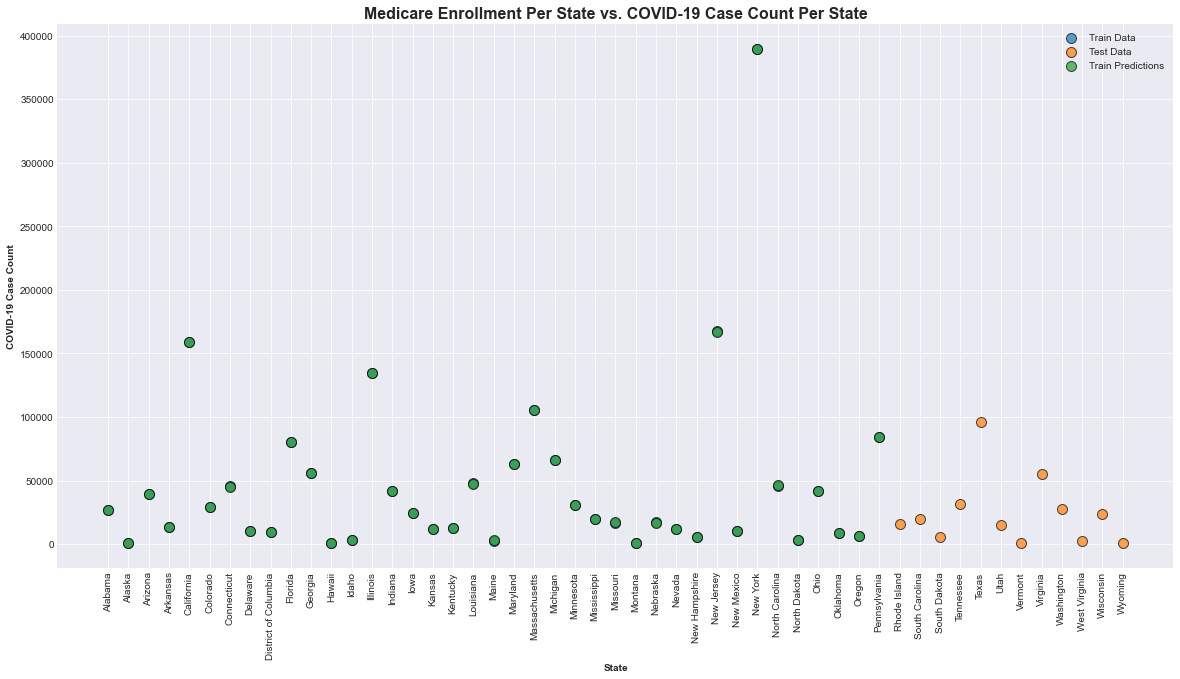

In [9]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

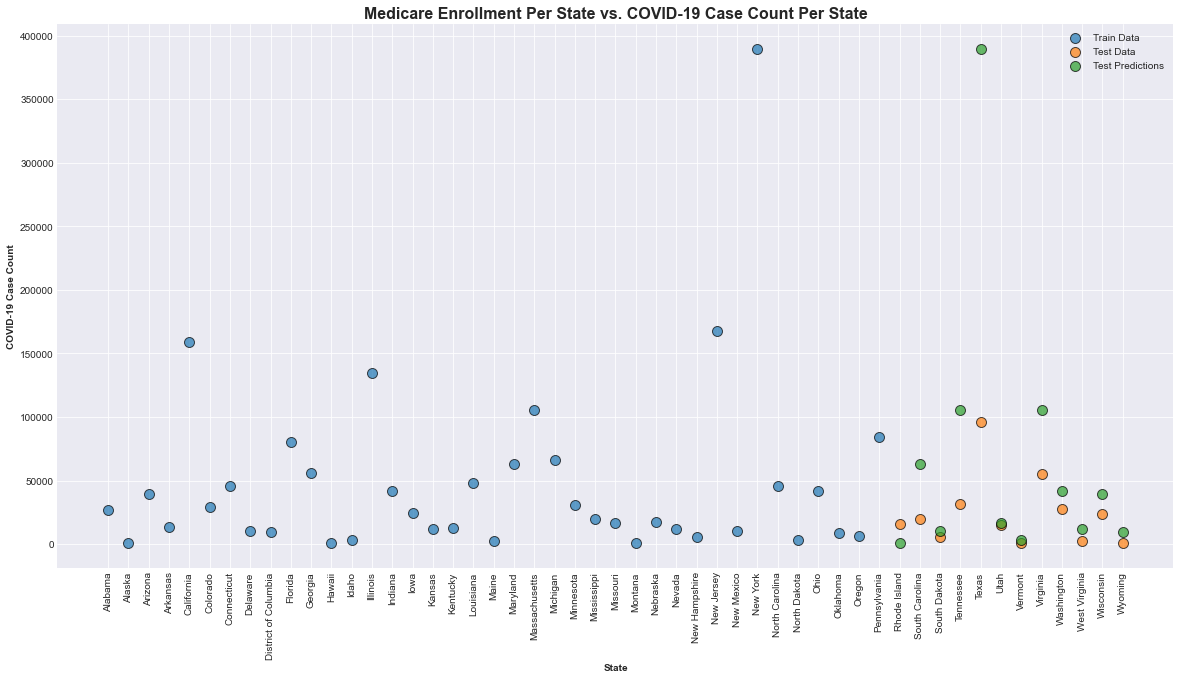

In [10]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [11]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


91.21906862086105

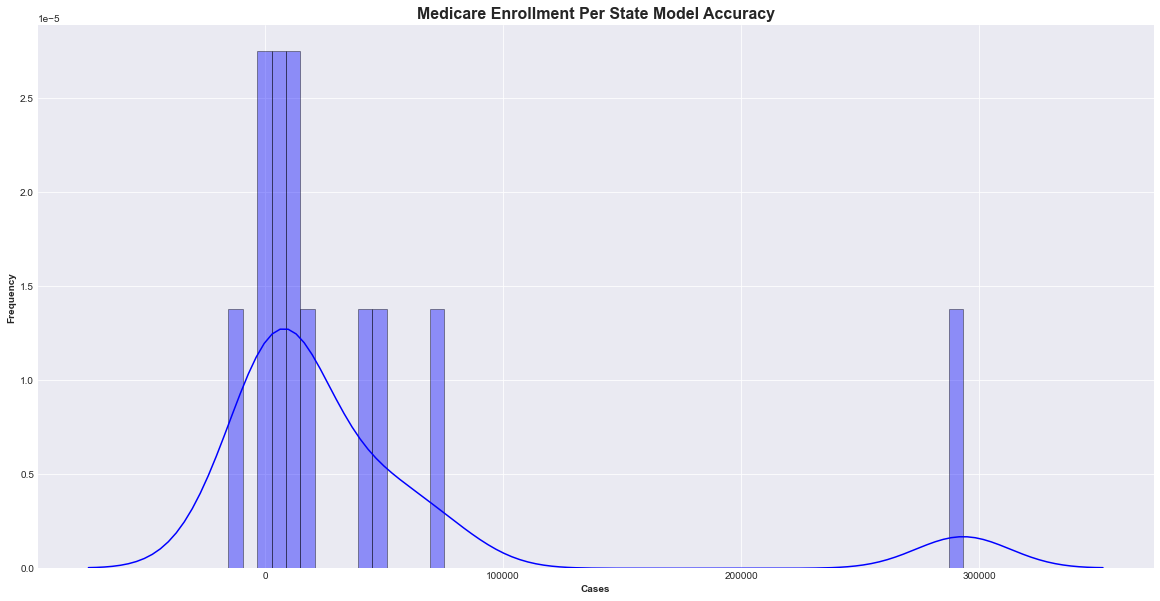

In [12]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Medicare Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [13]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 5386 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7248 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9274 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 11460 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 13810 tasks      

In [14]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.06,
 'max_depth': 1,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [15]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 22239.277243589742
Train MSE Value: 1913175080.954893
Train RMS Value: 43739.85689225438
Train R2 Score: 0.6047012517164543


Test MAE Value: 20320.5751953125
Test MSE Value: 849432350.9635226
Test RMS Value: 29145.02274769266
Test R2 Score: -0.23854601634317918


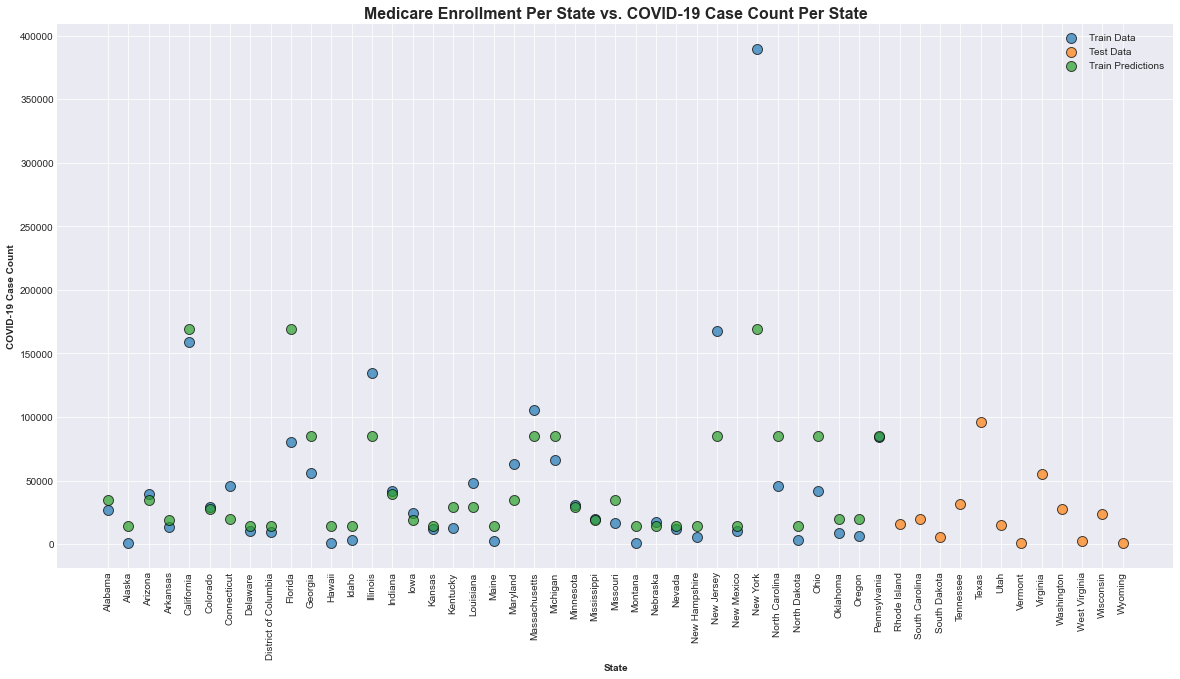

In [16]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

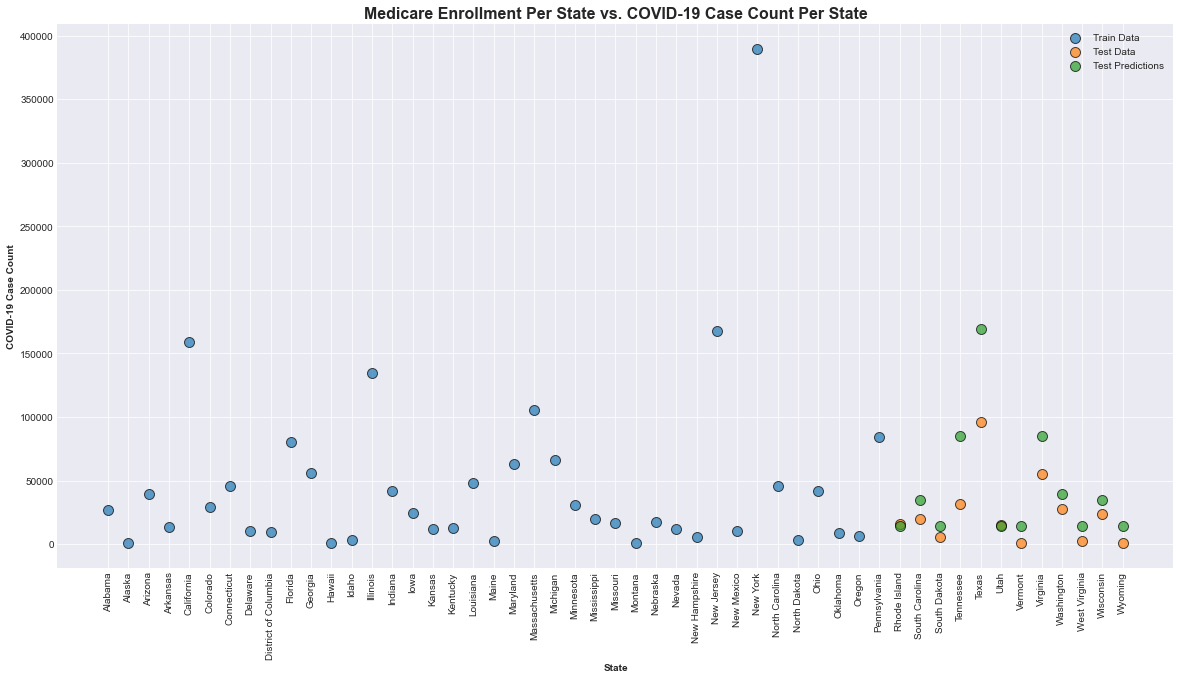

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicare Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [18]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


In [19]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7411 degrees.
Accuracy = 91.04%.


In [20]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of -0.20%.


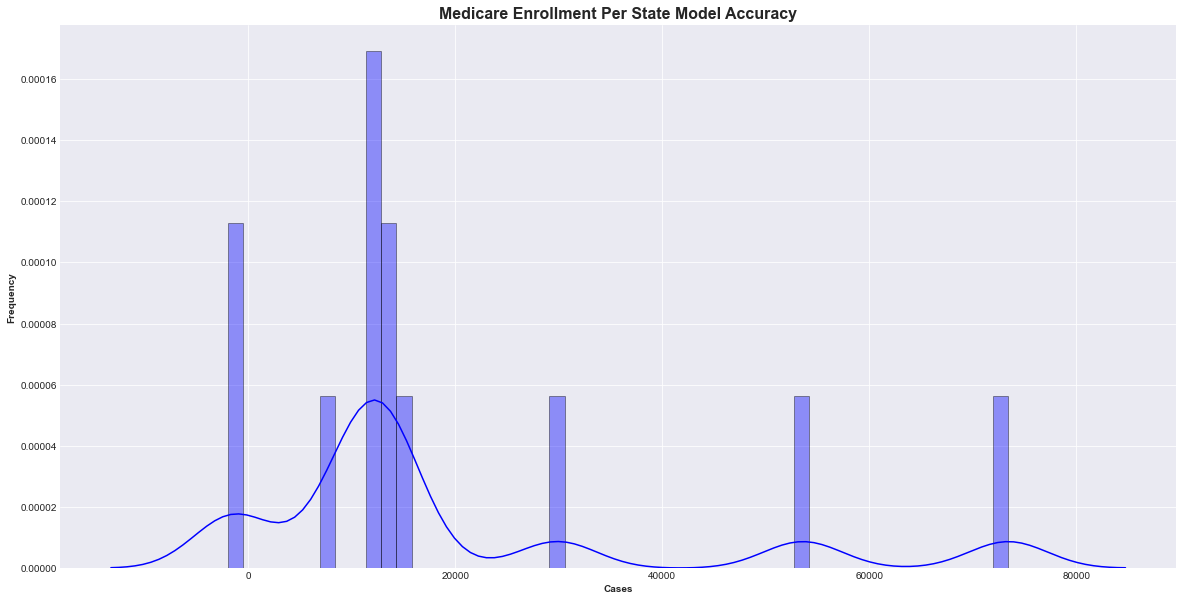

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Medicare Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [22]:
features_list = ['Medicaid Enrollment Per State (2014)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 267.08864339192706
Train MSE Value: 617725.051552416
Train RMS Value: 785.9548661039105
Train R2 Score: 0.9998723661299518


Test MAE Value: 15489.60513305664
Test MSE Value: 687753079.6802853
Test RMS Value: 26225.046800344997
Test R2 Score: -0.002803620676262941


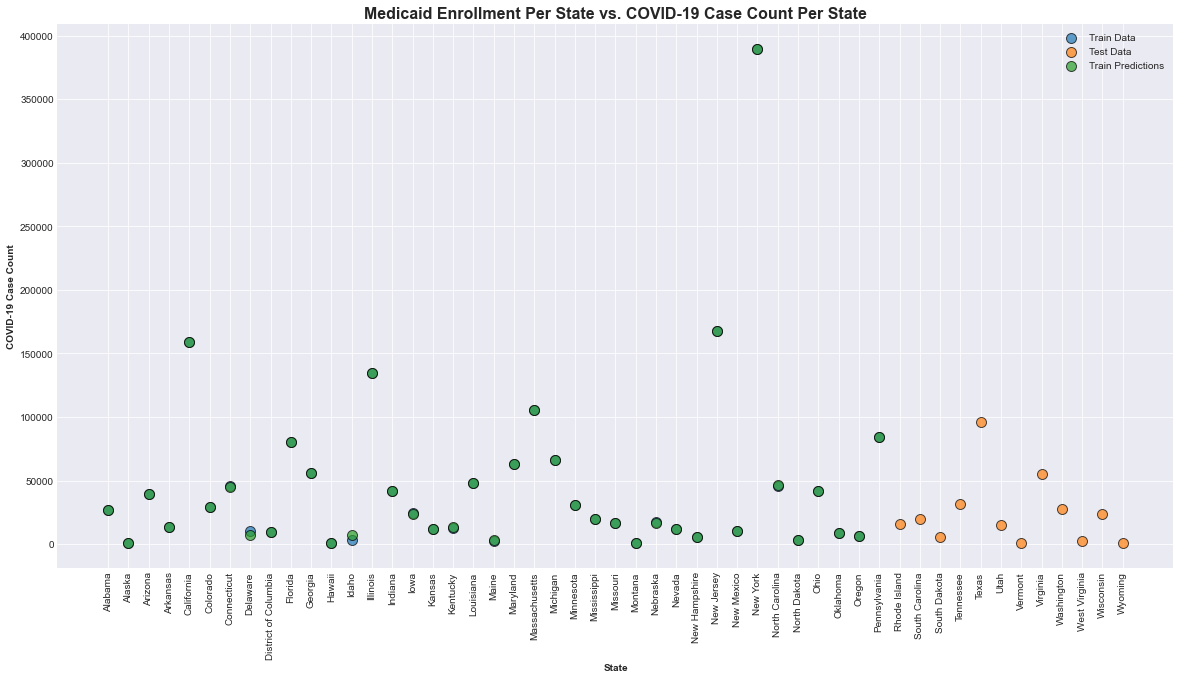

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


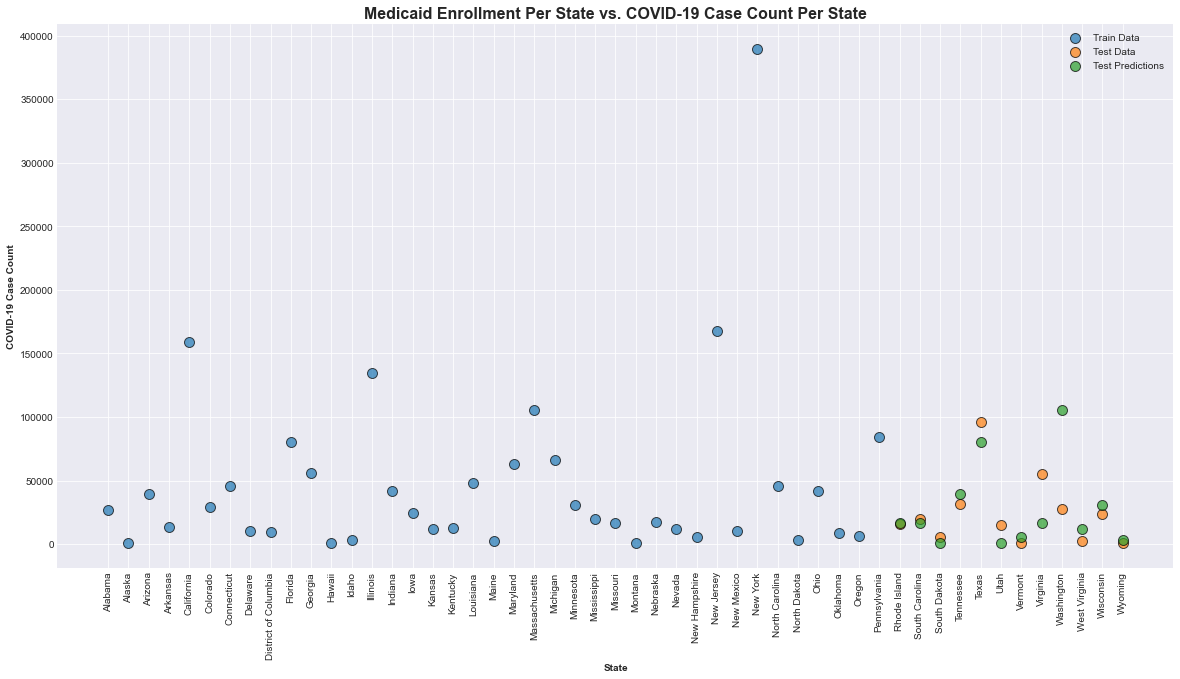

In [24]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [25]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8306 degrees.
Accuracy = 91.25%.


91.24694239984916

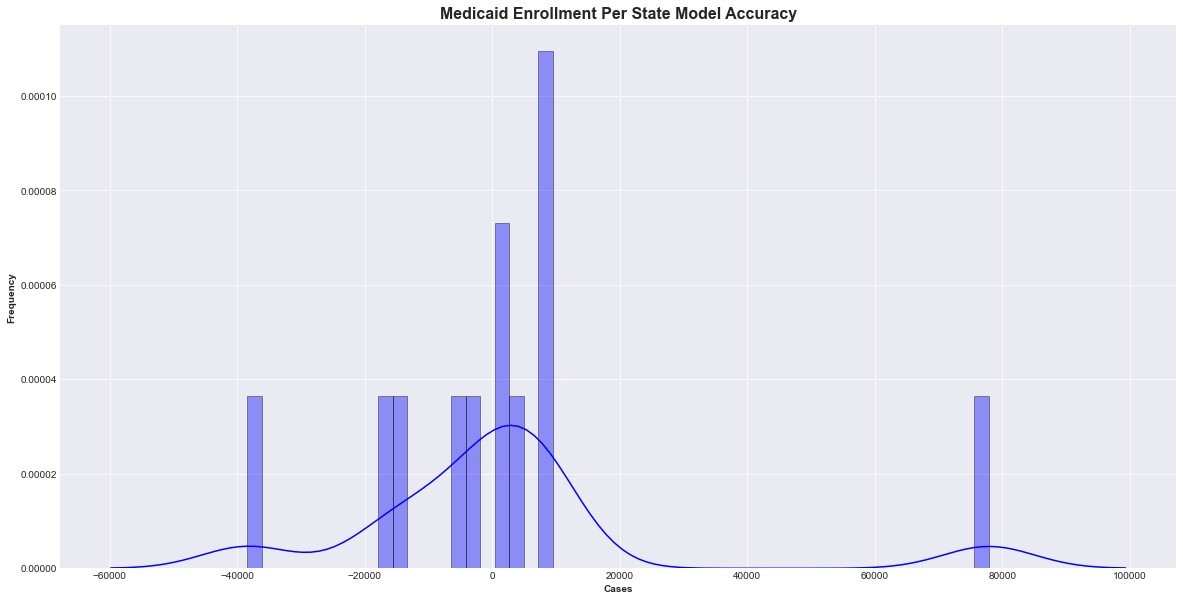

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Medicaid Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [27]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 6490 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9730 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 13618 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 15804 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 18154 tasks  

In [28]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.06,
 'max_depth': 3,
 'min_child_weight': 2,
 'reg_lambda': 10}

In [29]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 15289.90509815705
Train MSE Value: 1123428771.3415663
Train RMS Value: 33517.588984614726
Train R2 Score: 0.7678780204081525


Test MAE Value: 16020.890462239584
Test MSE Value: 792459981.3711392
Test RMS Value: 28150.66573584254
Test R2 Score: -0.1554753617816509


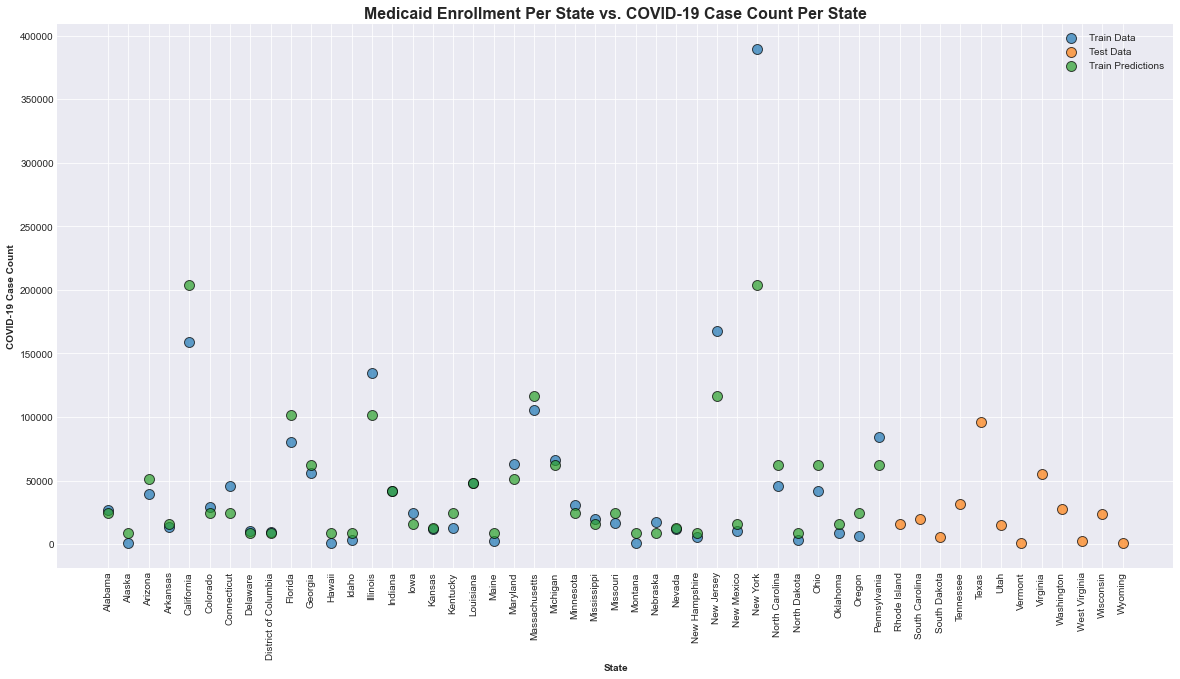

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


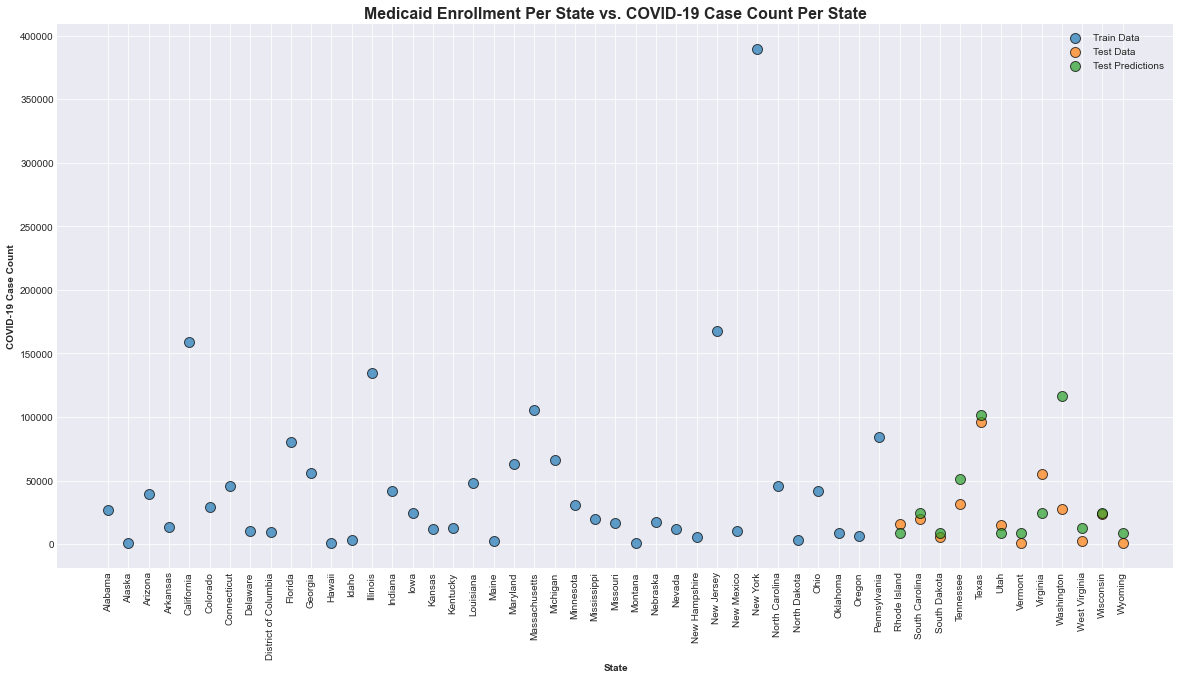

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Medicaid Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [32]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8306 degrees.
Accuracy = 91.25%.


In [33]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7516 degrees.
Accuracy = 91.93%.


In [34]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 0.75%.


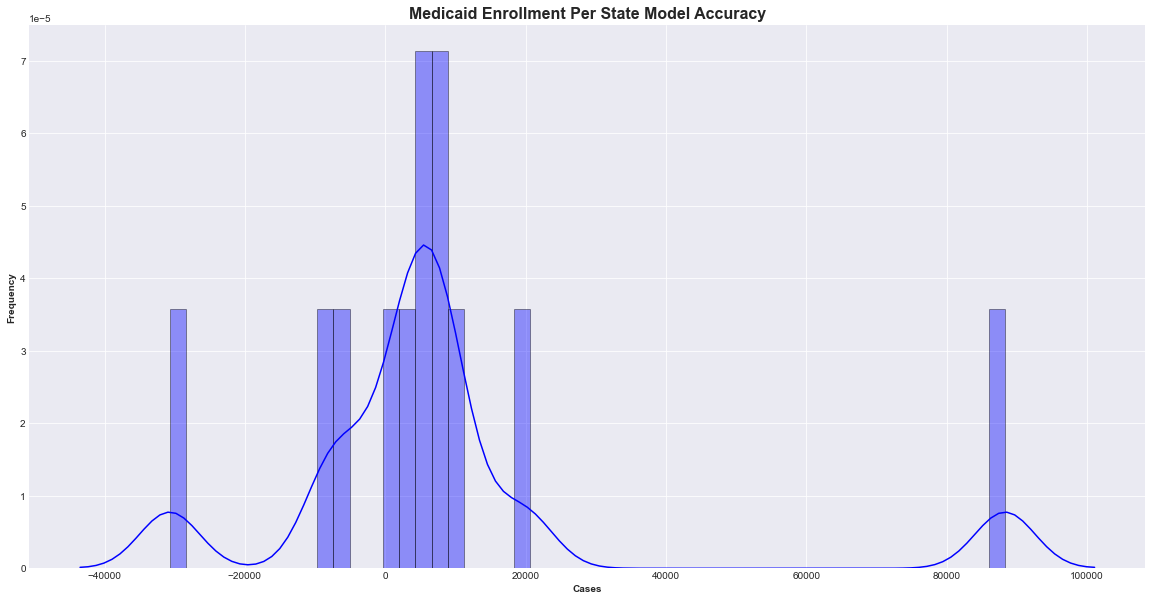

In [35]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Medicaid Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [36]:
features_list = [ 'Private Enrollment Per State (2014)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 339.03455841846954
Train MSE Value: 1070984.0080852357
Train RMS Value: 1034.8835722366239
Train R2 Score: 0.9997787141166314


Test MAE Value: 37777.27810160319
Test MSE Value: 7784265909.20025
Test RMS Value: 88228.4869483788
Test R2 Score: -10.350134617618313


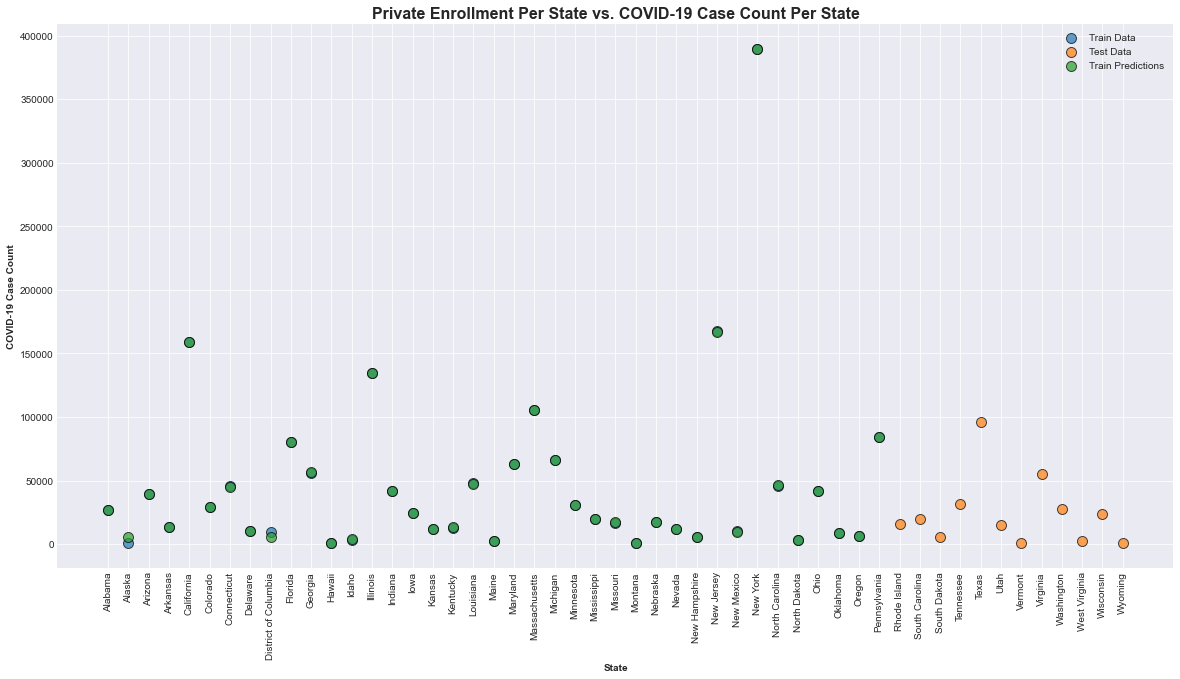

In [37]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Private Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

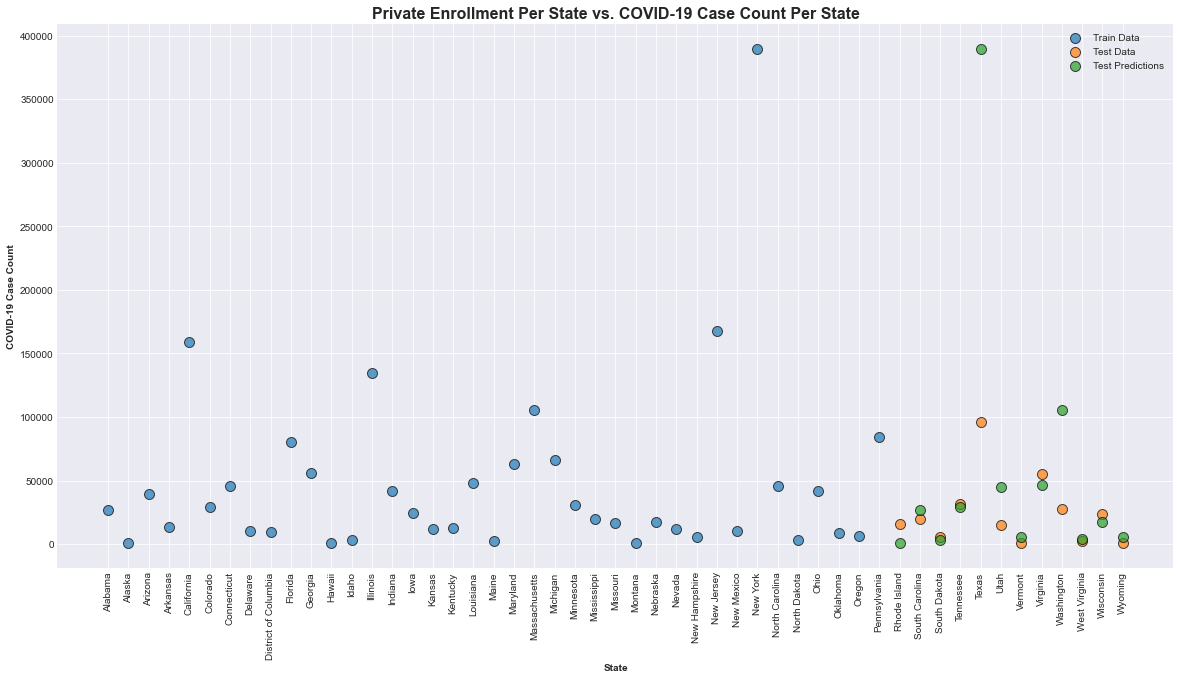

In [38]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Private Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [39]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8305 degrees.
Accuracy = 91.19%.


91.18874612705613

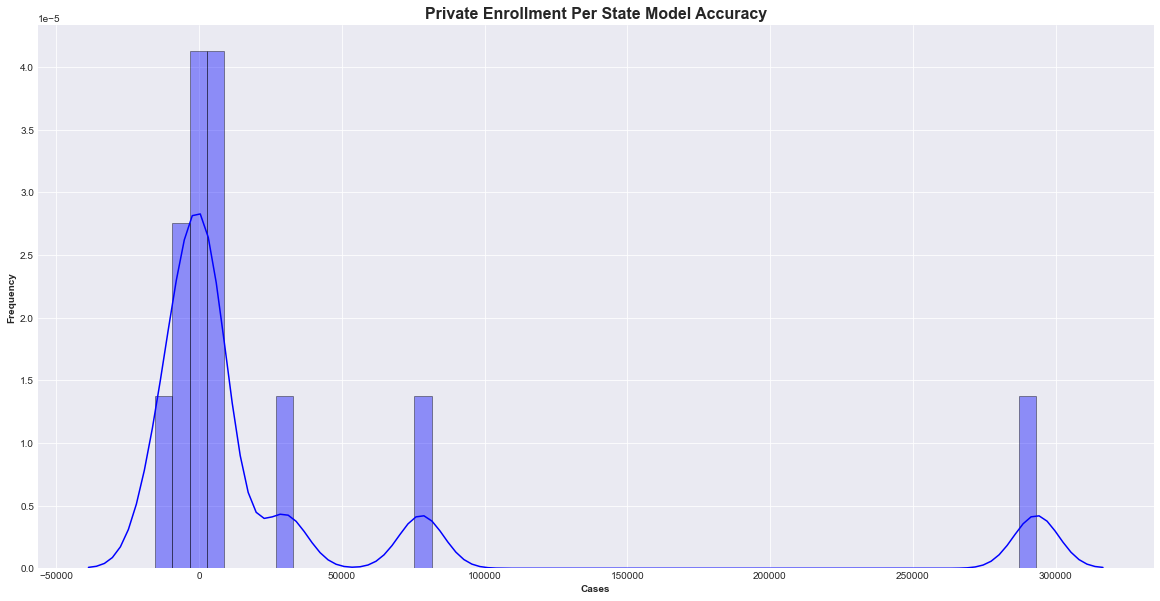

In [40]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Private Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [41]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6490 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9730 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 13618 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 15804 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 18154 tasks  

In [42]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 3,
 'reg_lambda': 10}

In [43]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 19665.920022035258
Train MSE Value: 1751282805.7934563
Train RMS Value: 41848.33097978289
Train R2 Score: 0.6381513077856302


Test MAE Value: 18169.220377604168
Test MSE Value: 787069503.822333
Test RMS Value: 28054.759022710085
Test R2 Score: -0.14761557814297954


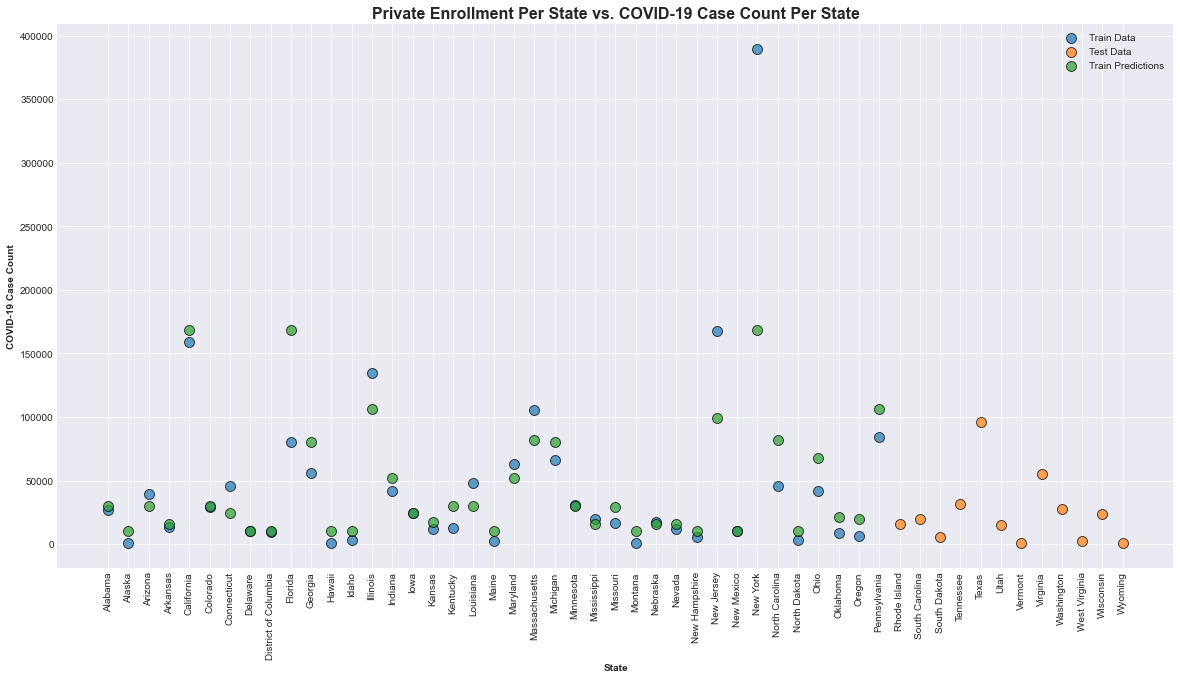

In [44]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Private Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

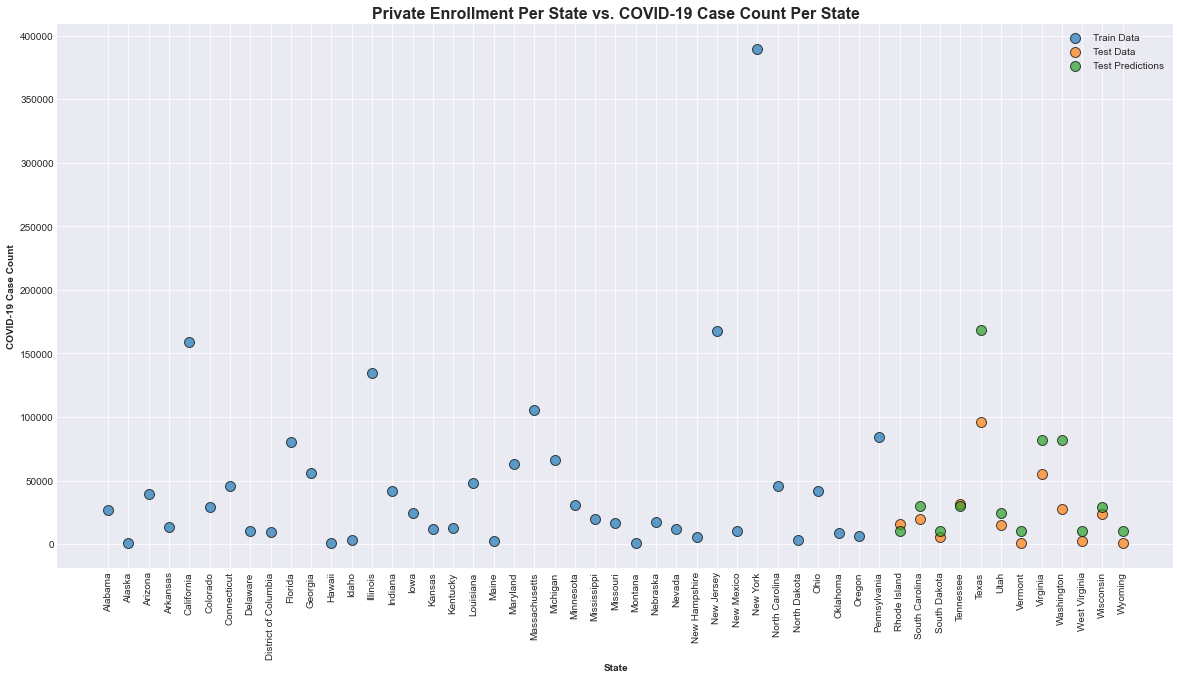

In [45]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Private Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [46]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8305 degrees.
Accuracy = 91.19%.


In [47]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7534 degrees.
Accuracy = 93.48%.


In [48]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 2.45%.


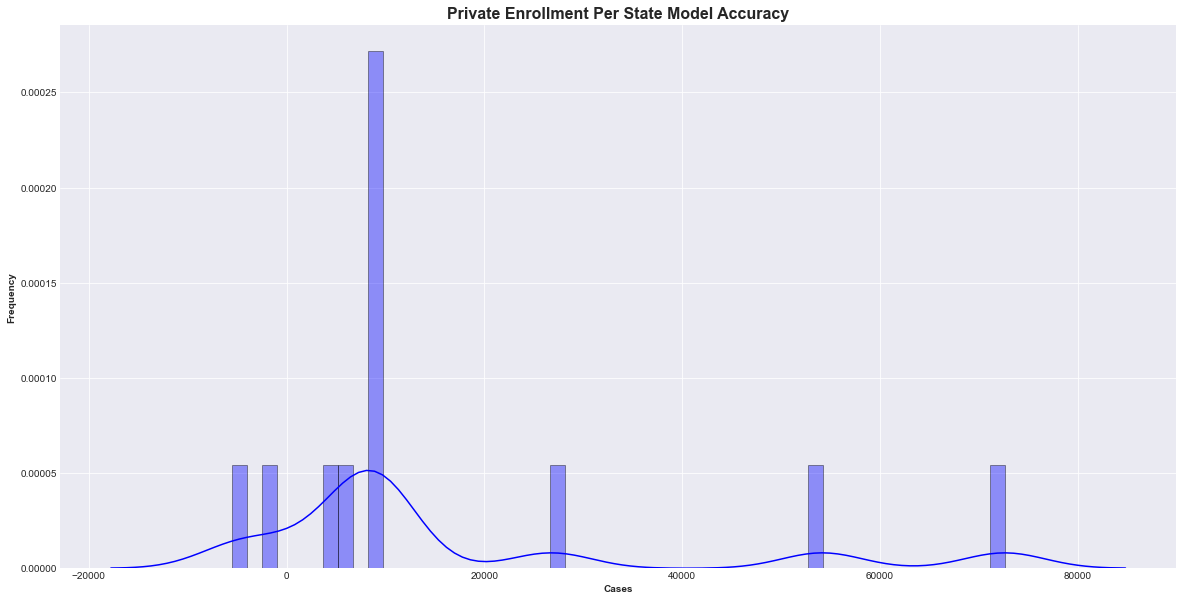

In [49]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Private Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [50]:
features_list = ['Total Health Insurance Enrollment Per State (2014)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 107.86867268880208
Train MSE Value: 17977.397778156
Train RMS Value: 134.07981868333505
Train R2 Score: 0.9999962855240433


Test MAE Value: 40607.139653523765
Test MSE Value: 7983219744.263686
Test RMS Value: 89348.86537759552
Test R2 Score: -10.640226559106656


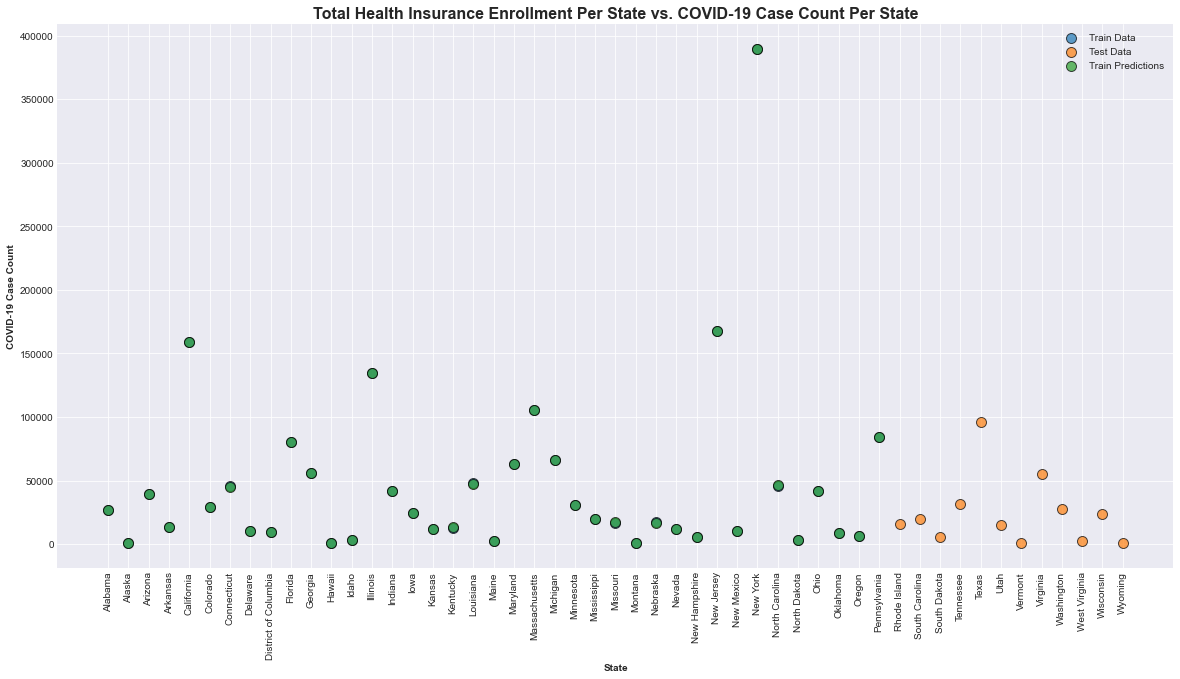

In [51]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Health Insurance Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

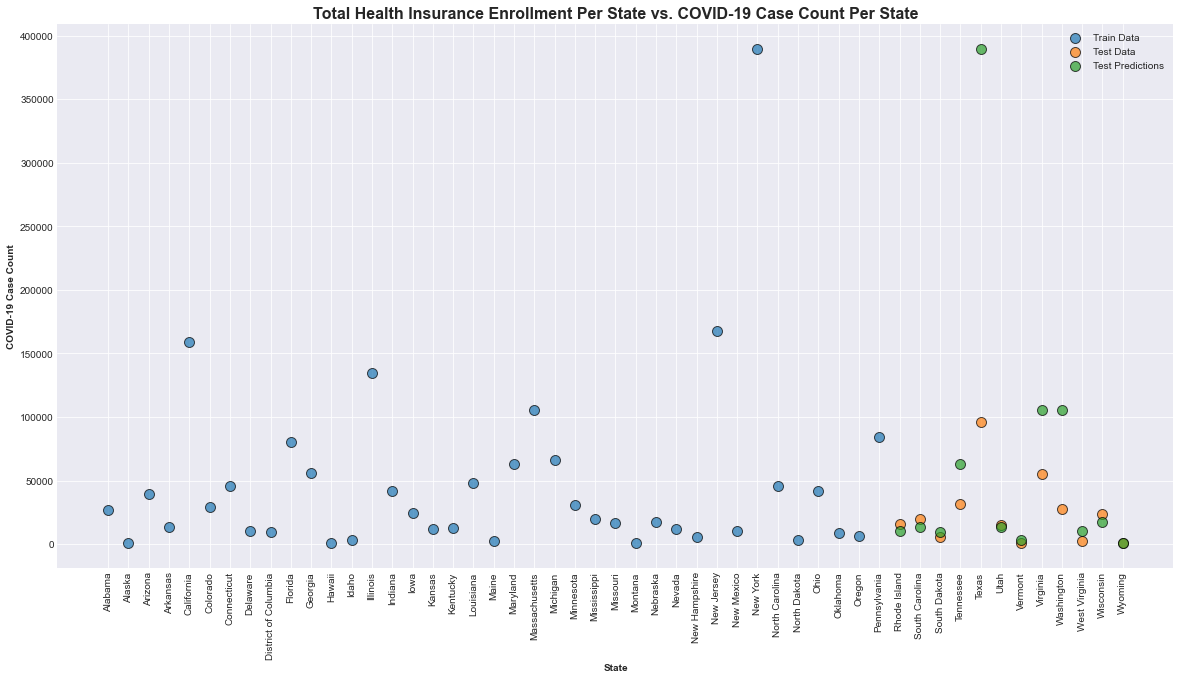

In [52]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Health Insurance Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [53]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


91.21939029895647

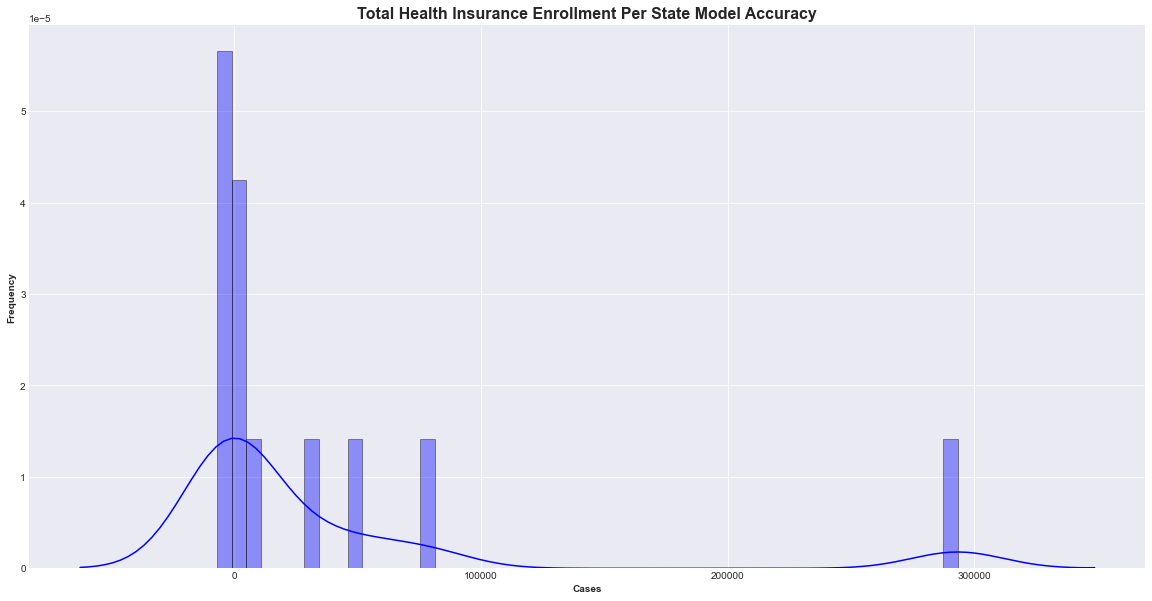

In [54]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Total Health Insurance Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [55]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 598 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1164 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1894 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2784 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 3838 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5052 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7968 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 9670 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 11532 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 13558 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 15744 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 18094 tasks  

In [56]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 2,
 'reg_lambda': 10}

In [57]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 15640.222155448719
Train MSE Value: 1244260040.870027
Train RMS Value: 35274.0703757027
Train R2 Score: 0.7429119574097403


Test MAE Value: 24888.3369140625
Test MSE Value: 1542533162.6740754
Test RMS Value: 39275.09596008742
Test R2 Score: -1.2491470939859042


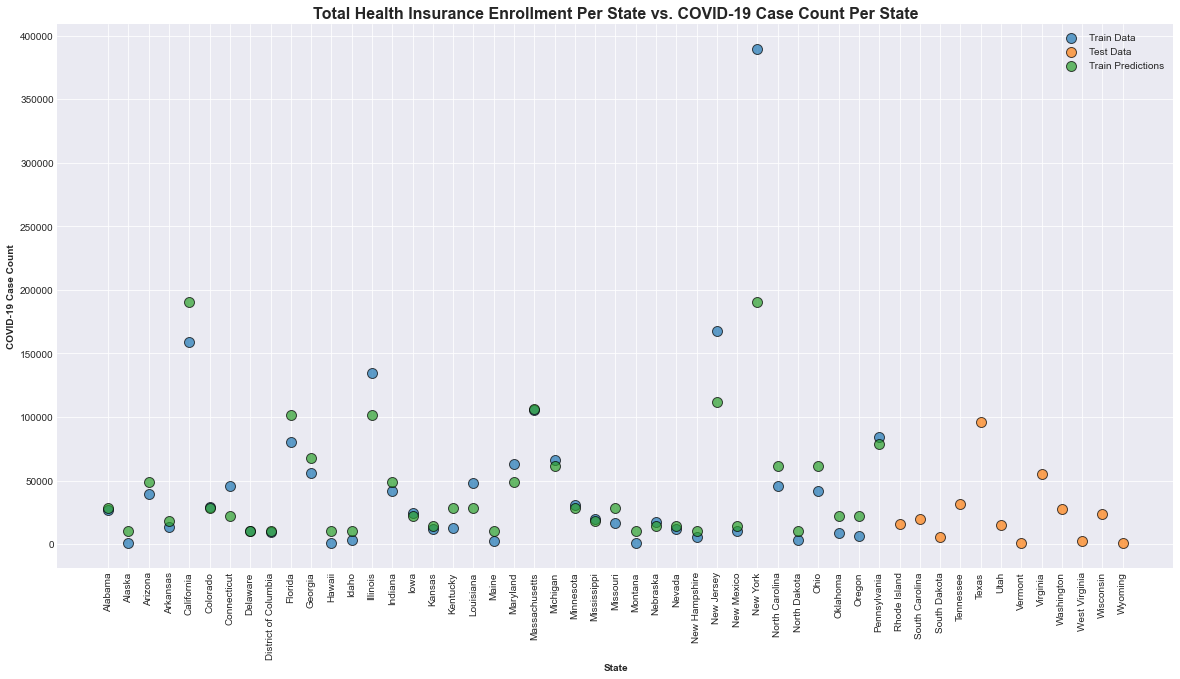

In [58]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Health Insurance Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

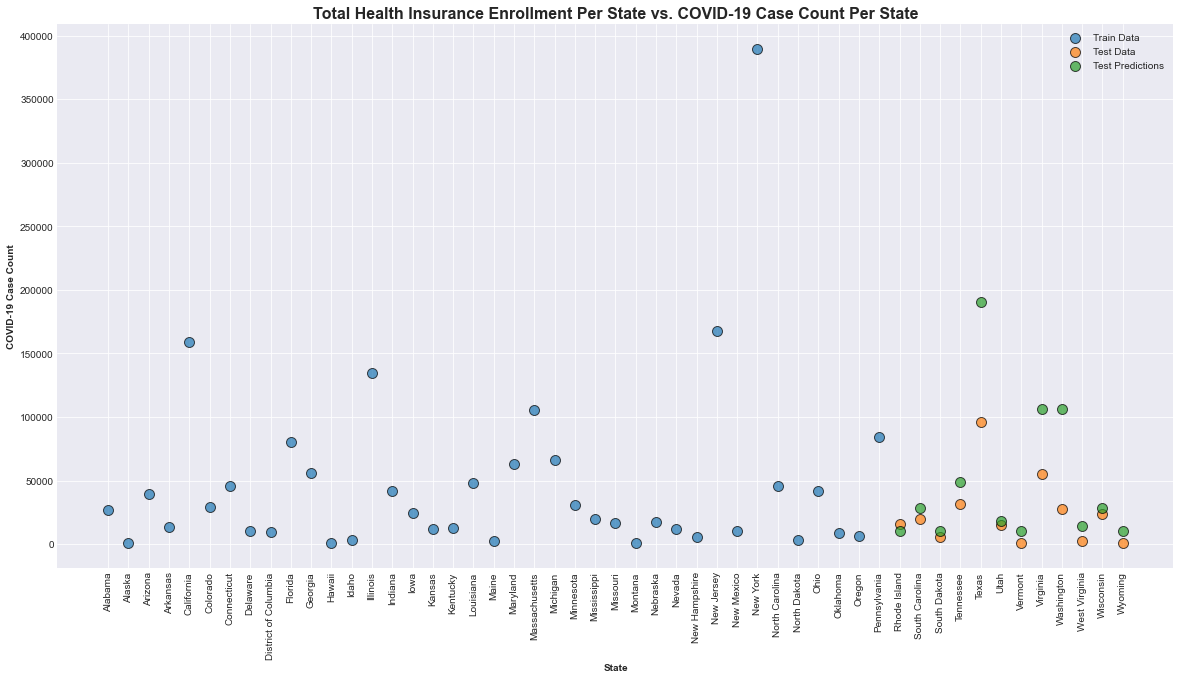

In [59]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Total Health Insurance Enrollment Per State vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [60]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8308 degrees.
Accuracy = 91.22%.


In [61]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7368 degrees.
Accuracy = 92.83%.


In [62]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of 1.73%.


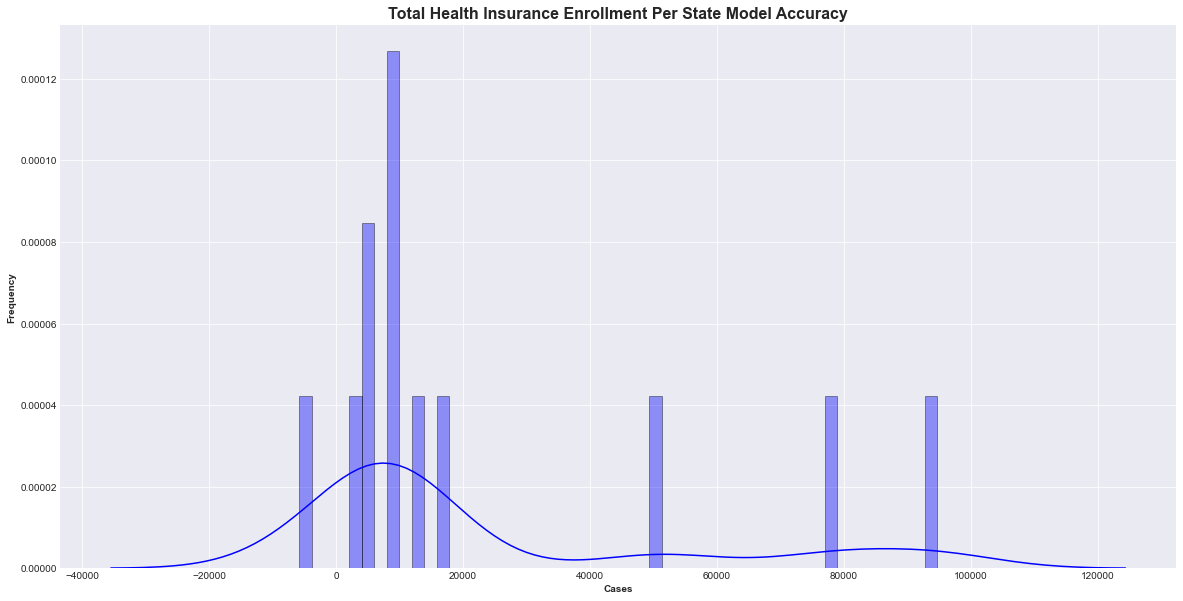

In [63]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Total Health Insurance Enrollment Per State Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [64]:
features_list = ['Medicare Enrollment Per State (2014)','Medicaid Enrollment Per State (2014)','Private Enrollment Per State (2014)','Total Health Insurance Enrollment Per State (2014)']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 64.55752485226363
Train MSE Value: 7109.293217536253
Train RMS Value: 84.3166247992426
Train R2 Score: 0.9999985310833608


Test MAE Value: 15838.660196940104
Test MSE Value: 528590494.7806738
Test RMS Value: 22991.095989114434
Test R2 Score: 0.2292692280381632


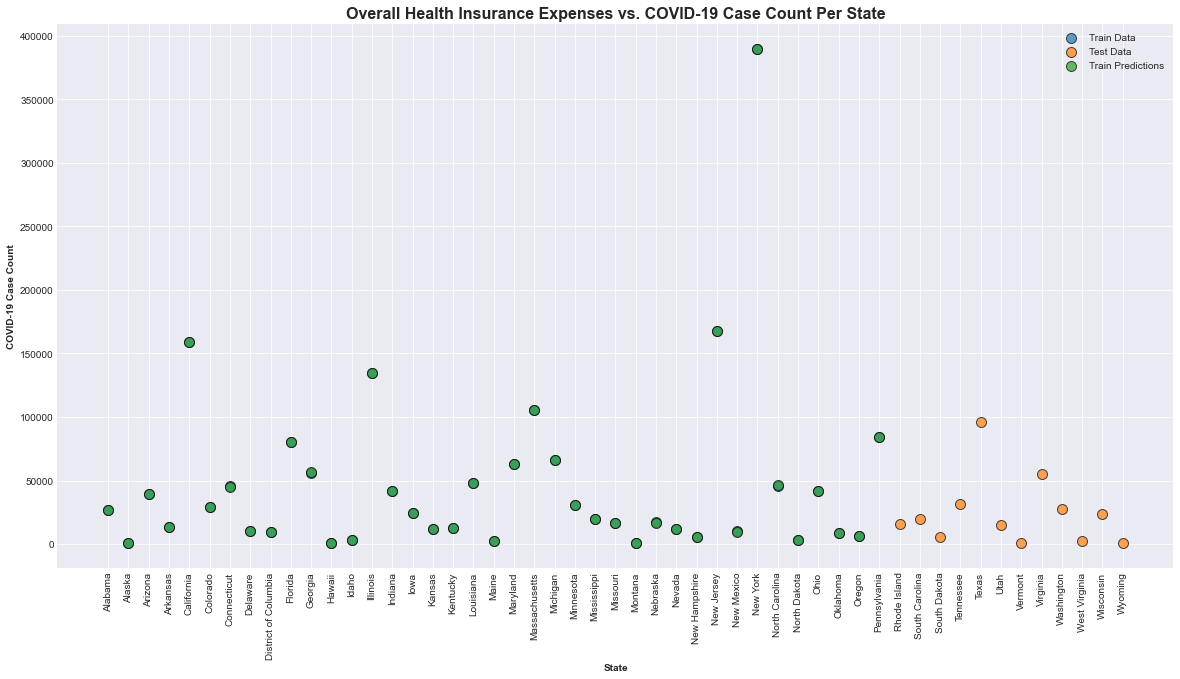

In [65]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Health Insurance Expenses vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

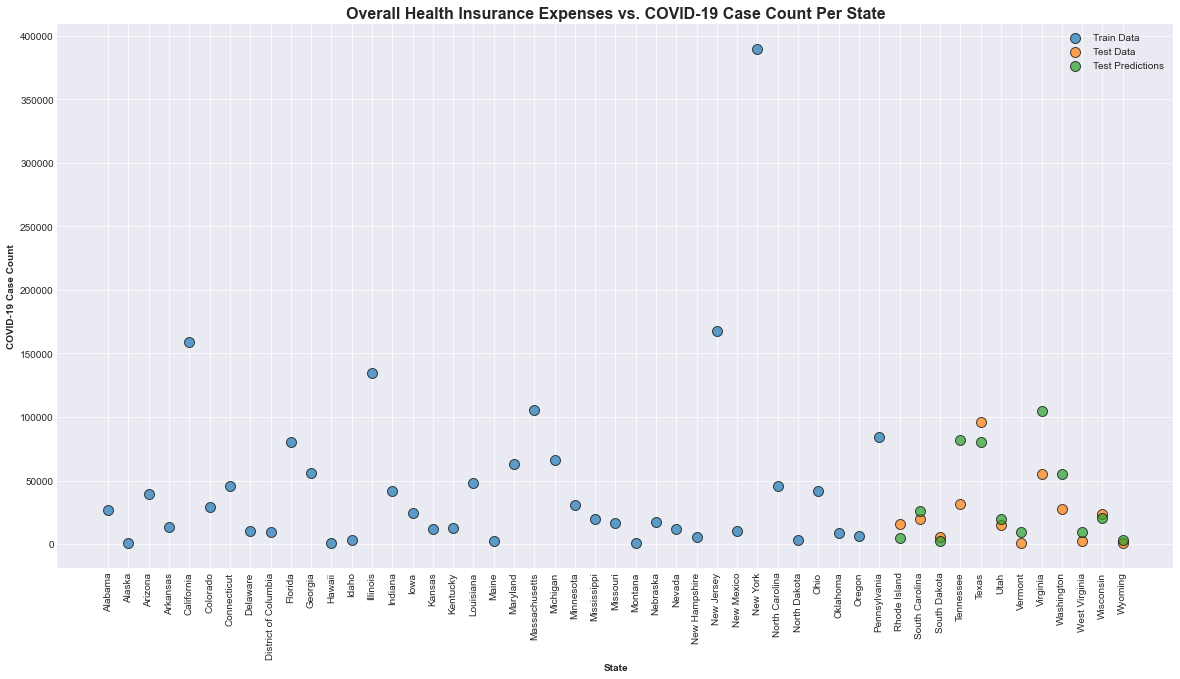

In [66]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Health Insurance Expenses vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [67]:
evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8309 degrees.
Accuracy = 91.25%.


91.24899235450235

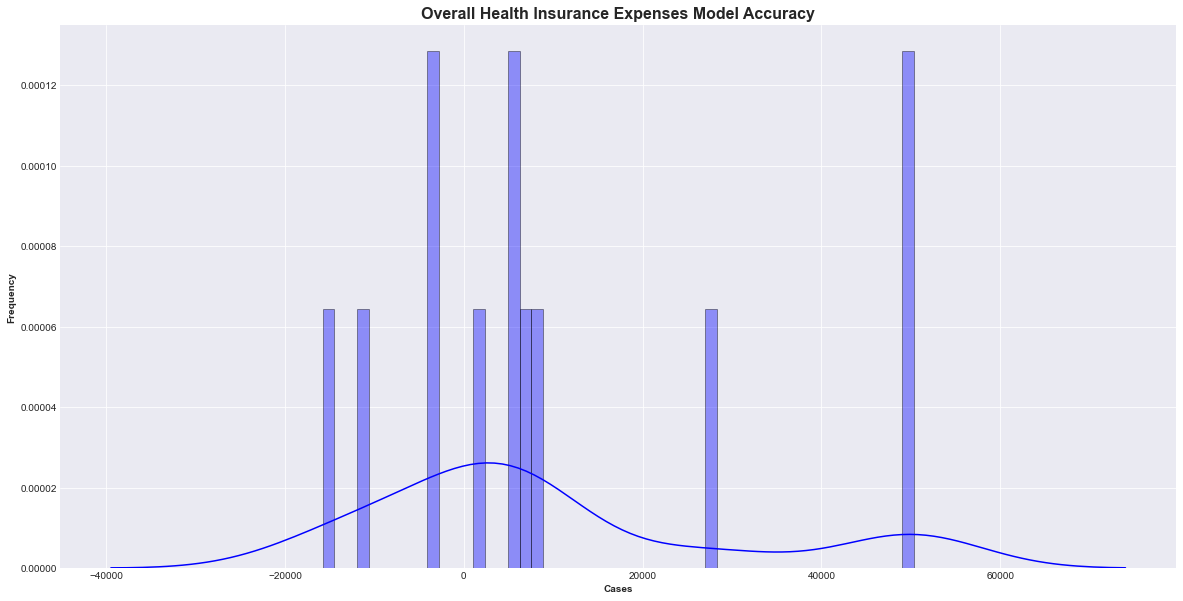

In [68]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Health Insurance Expenses Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [69]:
param_grid = {
    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "reg_lambda": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "colsample_bytree":[0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3]
}

kfold = KFold(n_splits = 7)

XG_GridModel = GridSearchCV(estimator = XGBmodel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

XG_NewModel = XG_GridModel.fit(X_train_scaled, y_train_scaled);

Fitting 7 folds for each of 7200 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 6490 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9730 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 11592 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 13618 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 15804 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 18154 tasks  

In [70]:
XG_NewModel.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.06,
 'max_depth': 1,
 'min_child_weight': 2,
 'reg_lambda': 10}

In [71]:
train_predictions_scaled = XG_NewModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XG_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 19236.0804286859
Train MSE Value: 1429915844.636546
Train RMS Value: 37814.228071409125
Train R2 Score: 0.7045518995294909


Test MAE Value: 13242.880208333334
Test MSE Value: 373578611.3626709
Test RMS Value: 19328.181791432708
Test R2 Score: 0.4552899941126419


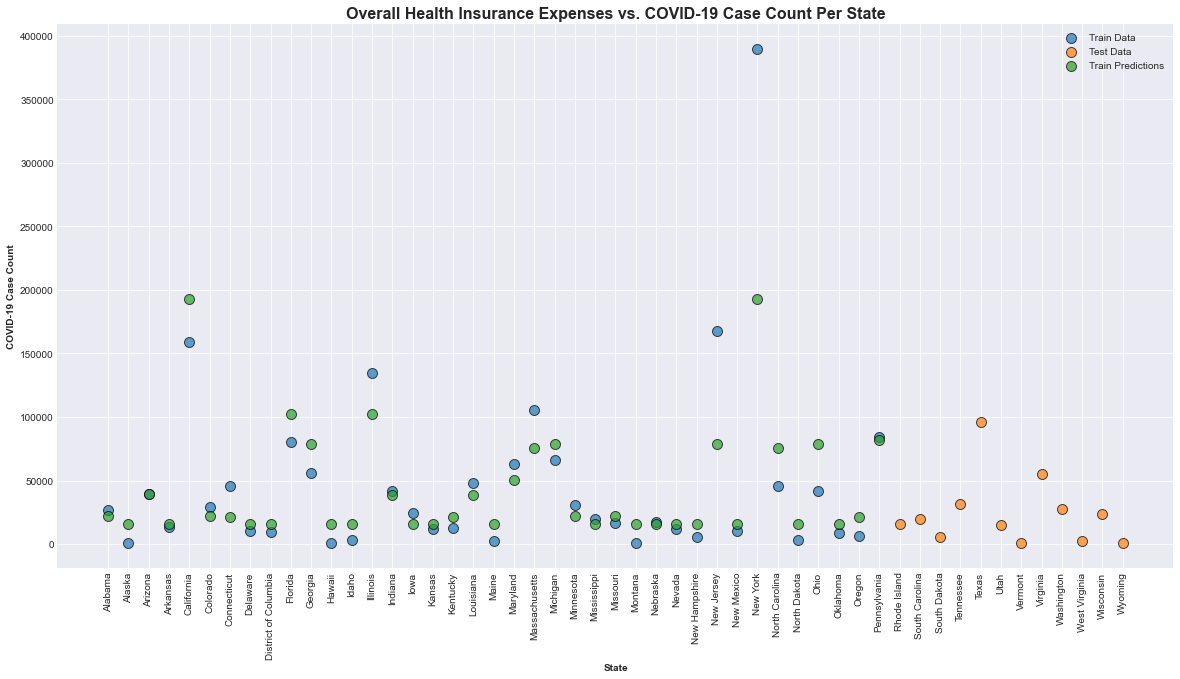

In [72]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Health Insurance Expenses vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

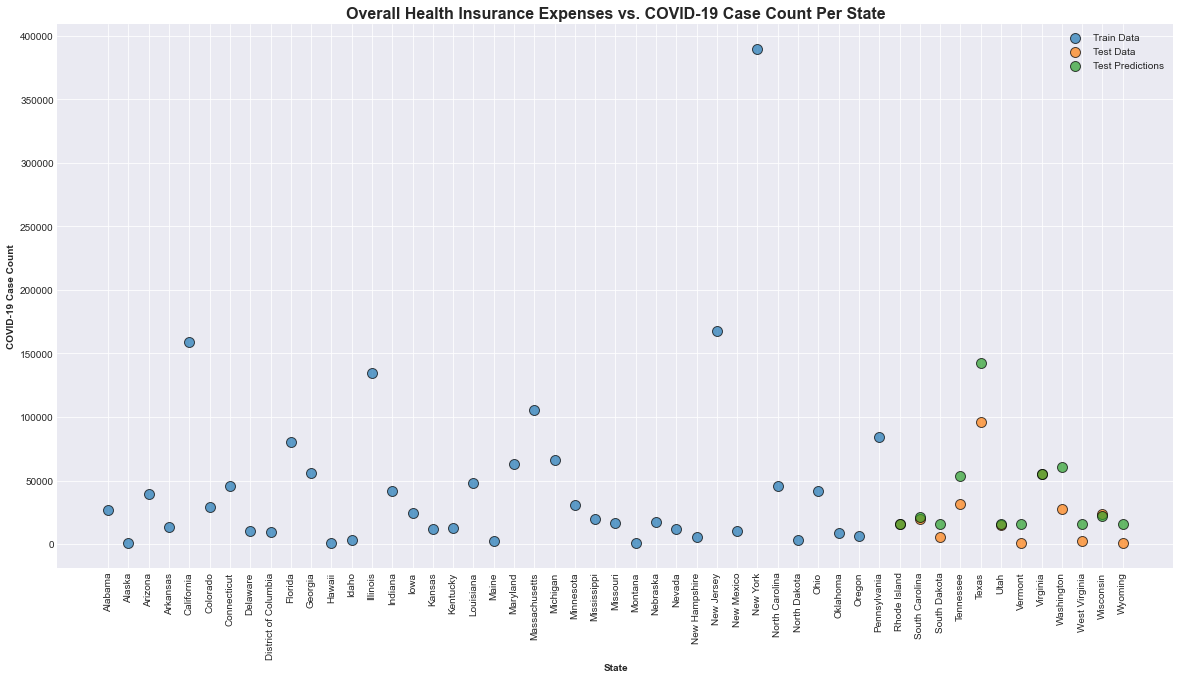

In [73]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Health Insurance Expenses vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [74]:
base_accuracy = evaluate(XGBmodel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.8309 degrees.
Accuracy = 91.25%.


In [75]:
new_accuracy = evaluate(XG_NewModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7299 degrees.
Accuracy = 90.55%.


In [76]:
print('Improvement of {:0.2f}%.'.format( 100 * (new_accuracy - base_accuracy) / new_accuracy))

Improvement of -0.77%.


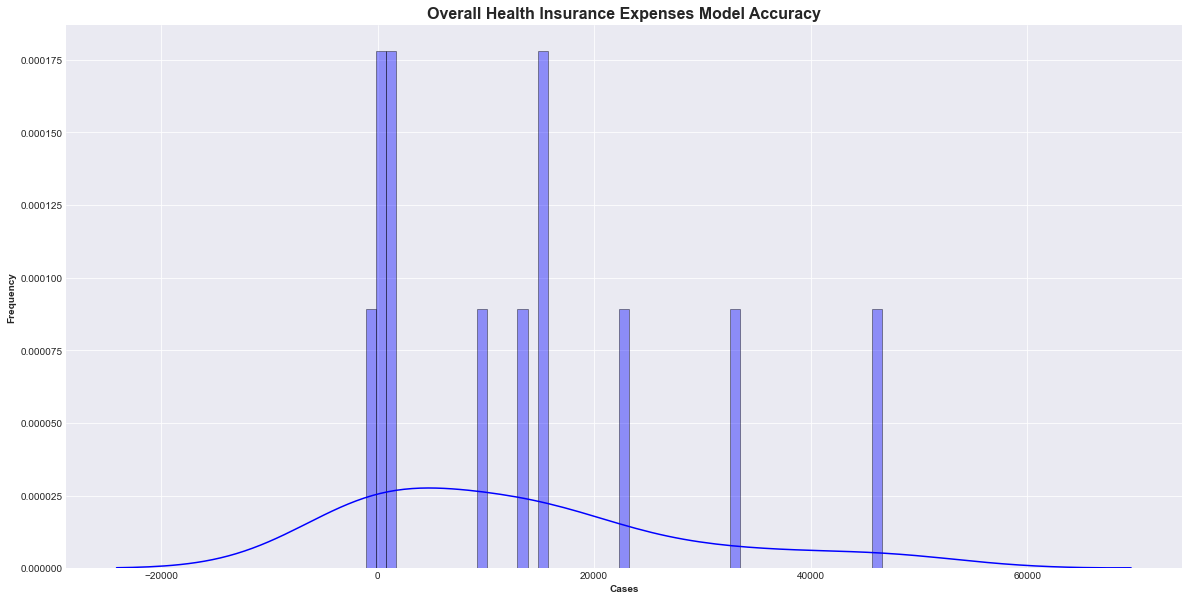

In [77]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Health Insurance Expenses Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();